In [1]:
import tensorflow as tf
import pickle
import numpy as np
import timeit
import load_cifar_template as lc
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
import time

from tqdm import tqdm
import scipy.io as spio
import pickle
import os
import cv2
import timeit
from skimage.transform import rescale, resize, downscale_local_mean

In [2]:
tf.reset_default_graph()

In [3]:
#learning rate
lr = 0.0001
#number of traning steps
num_steps = 10
#number of batch_size
batch_size = 5
#num_input = 784
num_classes = 3

In [4]:
#fetch the data

def fetch_data(directory, label): 
    item_list = []
    step = 0
    for file in tqdm(os.listdir(directory)):
        full_img_str = directory + "/" + file
        #print(full_img_str)

        mat = spio.loadmat(full_img_str, squeeze_me=True)
        data = np.abs(mat["data_store"])
        smaller_data = data[100:400]
        
        image_resized = resize(smaller_data, (100, 320, 4),
                       anti_aliasing=True)
        #print(data.shape)
        #print(data)
        ###append the img and label to the list###
        sub_list = [image_resized, label]
        #print(sub_list)
        item_list.append(sub_list)
        
    return item_list
    
bike1 = fetch_data("Desktop/ee596prepro/2019_04_09_bms1000/data", [1, 0, 0])
bike2 = fetch_data("Desktop/ee596prepro/2019_04_09_bms1001/data", [1, 0, 0])
bike3 = fetch_data("Desktop/ee596prepro/2019_04_09_bms1002/data", [1, 0, 0])

car1 = fetch_data("Desktop/ee596prepro/2019_04_09_cms1000/data", [0, 1, 0])
car2 = fetch_data("Desktop/ee596prepro/2019_04_09_cms1001/data", [0, 1, 0])
car3 = fetch_data("Desktop/ee596prepro/2019_04_09_cms1002/data", [0, 1, 0])

ped1 = fetch_data("Desktop/ee596prepro/2019_04_09_pms1000/data", [0, 0, 1])
ped2 = fetch_data("Desktop/ee596prepro/2019_04_09_pms1001/data", [0, 0, 1])
ped3 = fetch_data("Desktop/ee596prepro/2019_04_09_pms2000/data", [0, 0, 1])



#directory = "Desktop/ee596prepro/2019_04_09_bms1000/data"

100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.39it/s]


In [5]:
def mini_batch(features,labels,mini_batch_size):
    """
    Args:
        features: features for one batch
        labels: labels for one batch
        mini_batch_size: the mini-batch size you want to use.
    Hint: Use "yield" to generate mini-batch features and labels
    """
    #split the data into batches
    amount_of_data = len(features)
    number_of_bunches = amount_of_data/mini_batch_size
    
    bunches_features = []
    bunches_labels = []
    
    #loop over breaking the data into batches
    for i in range(int(number_of_bunches)):
        current_range = i * mini_batch_size
        f_b = features[current_range:current_range+mini_batch_size]
        l_b = labels[current_range:current_range+mini_batch_size]
        
        bunches_features.append(f_b)
        bunches_labels.append(l_b)
    
    #return the mini-batched data
    return bunches_features, bunches_labels

#full_list = bike1 + bike2 + bike3 + car1 + car2 + car3 + ped1 + ped2 + ped3
full_list = bike1 + car1 + ped1 + bike3 + car3 + ped3# + bike3 + car3 + ped3
test_list = bike2 + car2 + ped2

np.random.shuffle(full_list)
np.random.shuffle(test_list)

training_set = full_list#[0:2000]
valid_set = test_list[0:500]
test_set = test_list[500:997]


train_set_data = []
train_set_labels = []
valid_set_data = []
valid_set_labels = []
test_set_data = []
test_set_labels = []
#print(np.asarray(training_set).shape)
#print(training_set[0][0][0])
#print(training_set[0][:][1])
#print(training_set[0][:][0].shape)
#print(training_set[0][:][0])
#split into training, valid, and testing
for i in range(len(training_set)):
    train_set_data.append(training_set[i][0])
    train_set_labels.append(training_set[i][1])
    
for i in range(len(valid_set)):
    valid_set_data.append(valid_set[i][0])
    valid_set_labels.append(valid_set[i][1])

for i in range(len(test_set)):
    test_set_data.append(test_set[i][0])
    test_set_labels.append(test_set[i][1])

#print(np.asarray(train_set_data).shape)
#print(train_set_data.shape)


train_set_data, train_set_labels = mini_batch(train_set_data,train_set_labels,5)
valid_set_data, valid_set_labels = mini_batch(valid_set_data,valid_set_labels,5)
test_set_data, test_set_labels = mini_batch(test_set_data,test_set_labels,5)

#training_set = None
#valid_set = None
#test_set = None
#full_list = None
#bike1 = None
#car1 = None
#ped1 = None
#test_list = None

In [6]:
#tf graph input
X = tf.placeholder(tf.float32,[None,100,320,4],name='X')
Y = tf.placeholder(tf.int32,[None,num_classes],name='Y')

#TAKE ABS VALUE OF IMAGES

In [7]:
def VGG_like(x):    
    #first conv/pool pair
    #filters, then kernel size
    conv1 = tf.layers.conv2d(x, 30, 5, activation=tf.nn.relu)
    #conv1 = tf.layers.batch_normalization(conv1)
    #pool size, then stride
    pool1 = tf.layers.max_pooling2d(conv1, 2, 2)
    drop1 = tf.nn.dropout(pool1, 0.8)
    
    #second conv/pool pair
    conv2 = tf.layers.conv2d(drop1, 15, 3, activation=tf.nn.relu)
    #conv2 = tf.layers.batch_normalization(conv2)
    pool2 = tf.layers.max_pooling2d(conv2, 2, 2)
    drop2 = tf.nn.dropout(pool2, 0.8)
    
    #flatten to connect to fully connected
    full_in = flatten(drop2)
    
    #fully connected layer
    full1 = tf.contrib.layers.fully_connected(inputs=full_in, num_outputs=128, activation_fn=tf.nn.relu)
    #full1 = tf.layers.batch_normalization(full1)
    full1_d = tf.nn.dropout(full1, 0.8)
    full2 = tf.contrib.layers.fully_connected(inputs=full1_d, num_outputs=50, activation_fn=tf.nn.relu)
    full2_d = tf.nn.dropout(full2, 0.8)
    #full2 = tf.layers.batch_normalization(full2)
    logits = tf.contrib.layers.fully_connected(inputs=full2_d, num_outputs=num_classes, activation_fn=None)
    return logits

In [8]:
def VGG16(x):    
    #first conv/pool pair
    #filters, then kernel size
    conv1 = tf.layers.conv2d(x, 64, 3, activation=tf.nn.relu, padding = "same")
    conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu, padding = "same")
    #pool size, then stride
    pool2 = tf.layers.max_pooling2d(conv2, 2, 2) #usually 2,2 trying 5,5
    
    #filters, then kernel size
    conv3 = tf.layers.conv2d(pool2, 128, 3, activation=tf.nn.relu, padding = "same")
    conv4 = tf.layers.conv2d(conv3, 128, 3, activation=tf.nn.relu, padding = "same")
    #pool size, then stride
    pool4 = tf.layers.max_pooling2d(conv4, 2, 2)
    
    #filters, then kernel size
    conv5 = tf.layers.conv2d(pool4, 256, 3, activation=tf.nn.relu, padding = "same")
    conv6 = tf.layers.conv2d(conv5, 256, 3, activation=tf.nn.relu, padding = "same")
    conv7 = tf.layers.conv2d(conv6, 256, 3, activation=tf.nn.relu, padding = "same")
    #pool size, then stride
    pool7 = tf.layers.max_pooling2d(conv7, 2, 2)
    
    #filters, then kernel size
    conv8 = tf.layers.conv2d(pool7, 512, 3, activation=tf.nn.relu, padding = "same")
    conv9 = tf.layers.conv2d(conv8, 512, 3, activation=tf.nn.relu, padding = "same")
    conv10 = tf.layers.conv2d(conv9, 512, 3, activation=tf.nn.relu, padding = "same")
    #pool size, then stride
    pool10 = tf.layers.max_pooling2d(conv10, 2, 2)
    
    
    #filters, then kernel size
    conv11 = tf.layers.conv2d(pool10, 512, 3, activation=tf.nn.relu, padding = "same")
    conv12 = tf.layers.conv2d(conv11, 512, 3, activation=tf.nn.relu, padding = "same")
    conv13 = tf.layers.conv2d(conv12, 512, 3, activation=tf.nn.relu, padding = "same")
    #pool size, then stride
    pool13 = tf.layers.max_pooling2d(conv13, 2, 2)
    
    
    
    #flatten to connect to fully connected
    full_in = flatten(pool13)
    
    #fully connected layer
    full1 = tf.contrib.layers.fully_connected(inputs=full_in, num_outputs=4096, activation_fn=tf.nn.relu)
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=4096, activation_fn=tf.nn.relu)
    logits = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=num_classes, activation_fn=None)
    return logits

In [9]:
def ResNet50(x):    
    #first conv/pool pair
    #filters, then kernel size
    #first layer
    conv1 = tf.layers.conv2d(x, 64, 7, activation=tf.nn.relu, padding = "same")
    pool1 = tf.layers.max_pooling2d(conv1, 2, 2) #did 2 not 3
    
    #repeat x3
    #second layer with shortcuts
    shortcut2 = tf.layers.conv2d(pool1, 256, 1, activation=tf.nn.relu, padding = "same")
    conv2 = pool1
    for i in range(3):
        #filters, then kernel size
        conv2 = tf.layers.conv2d(conv2, 64, 1, activation=tf.nn.relu, padding = "same")
        conv2 = tf.layers.conv2d(conv2, 64, 3, activation=tf.nn.relu, padding = "same")
        conv2 = tf.layers.conv2d(conv2, 256, 1, activation=None, padding = "same")
        
        conv2 = shortcut2 + conv2
        conv2 = tf.nn.relu(conv2)
        shortcut2 = conv2
        
        
    
    #lose weight at the start of layers, first shortcut needs to be reshaped
    #filter, kernel, then stride
    shortcut3 = tf.layers.conv2d(conv2, 512, 1, 2, activation=tf.nn.relu) #changed filters
    conv3 = tf.layers.conv2d(conv2, 128, 1, 2, activation=tf.nn.relu) #need stride 2
    conv3 = tf.layers.conv2d(conv3, 128, 3, activation=tf.nn.relu, padding = "same")
    conv3 = tf.layers.conv2d(conv3, 512, 1, activation=None, padding = "same")
    conv3 = conv3 + shortcut3
    conv3 = tf.nn.relu(conv3)
    
    shortcut3 = conv3
    
    #third layer with shortcuts
    for i in range(3):
        #filters, then kernel size
        conv3 = tf.layers.conv2d(conv3, 128, 1, activation=tf.nn.relu, padding = "same")
        conv3 = tf.layers.conv2d(conv3, 128, 3, activation=tf.nn.relu, padding = "same")
        conv3 = tf.layers.conv2d(conv3, 512, 1, activation=None, padding = "same")
        
        conv3 = shortcut3 + conv3
        conv3 = tf.nn.relu(conv3)
        shortcut3 = conv3
    
    
    #lose weight at the start of layers, first shortcut needs to be reshaped
    #filter, kernel, then stride
    shortcut4 = tf.layers.conv2d(conv3, 1024, 1, 2, activation=tf.nn.relu)
    conv4 = tf.layers.conv2d(conv3, 256, 1, 2, activation=tf.nn.relu) #need stride 2
    conv4 = tf.layers.conv2d(conv4, 256, 3, activation=tf.nn.relu, padding = "same")
    conv4 = tf.layers.conv2d(conv4, 1024, 1, activation=None, padding = "same")
    conv4 = conv4 + shortcut4
    conv4 = tf.nn.relu(conv4)
    
    shortcut4 = conv4
    
    #fourth layer with shortcuts
    for i in range(5):
        #filters, then kernel size
        conv4 = tf.layers.conv2d(conv4, 256, 1, activation=tf.nn.relu, padding = "same")
        conv4 = tf.layers.conv2d(conv4, 256, 3, activation=tf.nn.relu, padding = "same")
        conv4 = tf.layers.conv2d(conv4, 1024, 1, activation=None, padding = "same")
        
        conv4 = shortcut4 + conv4
        conv4 = tf.nn.relu(conv4)
        shortcut4 = conv4
    
    #lose weight at the start of layers, first shortcut needs to be reshaped
    #filter, kernel, then stride
    shortcut5 = tf.layers.conv2d(conv4, 2048, 1, 2, activation=tf.nn.relu)
    conv5 = tf.layers.conv2d(conv4, 512, 1, 2, activation=tf.nn.relu) #need stride 2
    conv5 = tf.layers.conv2d(conv5, 512, 3, activation=tf.nn.relu, padding = "same")
    conv5 = tf.layers.conv2d(conv5, 2048, 1, activation=None, padding = "same")
    conv5 = conv5 + shortcut5
    conv5 = tf.nn.relu(conv5)
    
    shortcut5 = conv5
    
    #fifth layer with shortcuts
    for i in range(2):
        #filters, then kernel size
        conv5 = tf.layers.conv2d(conv5, 512, 1, activation=tf.nn.relu, padding = "same")
        conv5 = tf.layers.conv2d(conv5, 512, 3, activation=tf.nn.relu, padding = "same")
        conv5 = tf.layers.conv2d(conv5, 2048, 1, activation=None, padding = "same")
        
        conv5 = shortcut5 + conv5
        conv5 = tf.nn.relu(conv5)
        shortcut5 = conv5
    
    #do an average pool, 7 by 7
    pool5 = tf.layers.average_pooling2d(conv5, 7, 7)
    
    
    #flatten to connect to fully connected
    full_in = flatten(pool5)
    
    #fully connected layer
    full1 = tf.contrib.layers.fully_connected(inputs=full_in, num_outputs=1000, activation_fn=tf.nn.relu)
    logits = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=num_classes, activation_fn=None)
    return logits

In [10]:
def LeNet(x):    
    #first conv/pool pair
    conv1 = tf.layers.conv2d(x, 6, 5, activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(conv1, 2, 2)
    
    #second conv/pool pairr
    conv2 = tf.layers.conv2d(pool1, 16, 5, activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(conv2, 2, 2)
    
    #flatten to connect to fully connected
    full_in = flatten(pool2)
    
    #fully connected layer
    full1 = tf.contrib.layers.fully_connected(inputs=full_in, num_outputs=120, activation_fn=tf.nn.relu)
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=84, activation_fn=tf.nn.relu)
    logits = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=num_classes, activation_fn=None)
    return logits

In [11]:
def AlexNet(x):    
    #first conv/pool pair
    #6 num of filters
    #5 kernel size
    conv1 = tf.layers.conv2d(inputs = x, filters = 96, kernel_size = 11, strides=(4, 4), activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs = conv1, pool_size = 3, strides = 2)
    
    
    #second conv/pool pair
    conv2 = tf.layers.conv2d(inputs = pool1, filters = 256, kernel_size = 5, strides=(1, 1), activation=tf.nn.relu, padding = "same")
    pool2 = tf.layers.max_pooling2d(conv2, 3, 2)
    
    #third fourth and fifth convs
    conv3 = tf.layers.conv2d(inputs = pool2, filters = 384, kernel_size = 3, strides=(1, 1), activation=tf.nn.relu, padding = "same")
    conv4 = tf.layers.conv2d(inputs = conv3, filters = 384, kernel_size = 3, strides=(1, 1), activation=tf.nn.relu, padding = "same")
    conv5 = tf.layers.conv2d(inputs = conv4, filters = 256, kernel_size = 3, strides=(1, 1), activation=tf.nn.relu, padding = "same")
    pool5 = tf.layers.max_pooling2d(conv5, 3, 2)
    #drop5 = tf.nn.dropout(pool5, 0.8)
    
    #flatten to connect to fully connected
    full_in = flatten(pool5)
    
    #fully connected layer
    full1 = tf.contrib.layers.fully_connected(inputs=full_in, num_outputs=4096, activation_fn=tf.nn.relu)
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=4096, activation_fn=tf.nn.relu)
    logits = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=num_classes, activation_fn=None)
    return logits

In [12]:
#predicted labels
logits = AlexNet(X)

#define loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y),name='loss')
#define optimizer
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)
#optimizer = tf.train.AdamOptimizer()
#train_op = optimizer.minimize(loss)

#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.


step 0, Accuracy training= 0.785
step 0, Accuracy= 0.848
--- 60.96154165267944 seconds ---
step 1, Accuracy training= 0.947
step 1, Accuracy= 0.814
--- 14.575389623641968 seconds ---
step 2, Accuracy training= 0.982
step 2, Accuracy= 0.828
--- 14.519851446151733 seconds ---
step 3, Accuracy training= 0.987
step 3, Accuracy= 0.794
--- 14.517188310623169 seconds ---
step 4, Accuracy training= 0.993
step 4, Accuracy= 0.814
--- 14.476482629776001 seconds ---
step 5, Accuracy training= 0.998
step 5, Accuracy= 0.874
--- 15.950896501541138 seconds ---
step 6, Accuracy training= 1.000
step 6, Accuracy= 0.876
--- 15.895490407943726 seconds ---
step 7, Accuracy training= 1.000
step 7, Accuracy= 0.876
--- 14.526563167572021 seconds ---
step 8, Accuracy training= 1.000
step 8, Accuracy= 0.878
--- 16.067502975463867 seconds ---
step 9, Accuracy training= 1.000
step 9, Accuracy= 0.878
--- 14.488955974578857 seconds ---
Training finished!
step 0, Accuracy training= 0.758
step 0, Accuracy= 0.846
--- 1

step 7, Accuracy= 0.882
--- 14.570802211761475 seconds ---
step 8, Accuracy training= 1.000
step 8, Accuracy= 0.884
--- 14.613813638687134 seconds ---
step 9, Accuracy training= 1.000
step 9, Accuracy= 0.884
--- 14.550798654556274 seconds ---
Training finished!
step 0, Accuracy training= 0.756
step 0, Accuracy= 0.800
--- 14.620809078216553 seconds ---
step 1, Accuracy training= 0.935
step 1, Accuracy= 0.854
--- 14.600276708602905 seconds ---
step 2, Accuracy training= 0.974
step 2, Accuracy= 0.758
--- 14.586184024810791 seconds ---
step 3, Accuracy training= 0.983
step 3, Accuracy= 0.856
--- 14.59098482131958 seconds ---
step 4, Accuracy training= 0.994
step 4, Accuracy= 0.808
--- 14.541120529174805 seconds ---
step 5, Accuracy training= 0.999
step 5, Accuracy= 0.866
--- 14.600903749465942 seconds ---
step 6, Accuracy training= 1.000
step 6, Accuracy= 0.870
--- 14.622015237808228 seconds ---
step 7, Accuracy training= 1.000
step 7, Accuracy= 0.870
--- 14.56993579864502 seconds ---
step

Text(0.5, 1.0, 'Epoch vs accuracy')

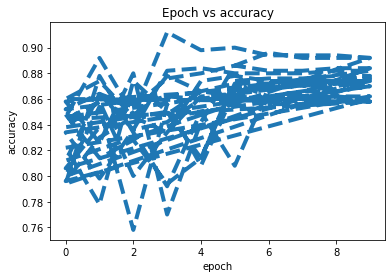

In [16]:
#Initialize the variables
def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    #config.gpu_options.allow_growth = True
    #config.gpu_options.allocator_type ='BFC'
    #config.gpu_options.per_process_gpu_memory_fraction = 0.90
    session = tf.Session(config=config)
    return session
sess = get_session()

#Initialize the variables
init = tf.global_variables_initializer()

acc_list = []
steps = []

#create a checkpoint system
saver = tf.train.Saver()
#save_dir = 'checkpoints/VGG_like/'
save_dir = 'checkpoints/AlexNet/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)     
save_path = os.path.join(save_dir, 'best_validation')

best_valid = 0

while best_valid < 0.9:
    acc_list = []
    steps = []
    #with tf.Session() as sess:
    sess.run(init)

    for i in range(num_steps):
        start_time = time.time()
        #epoch training
        acc_t = 0
        for j in range(len(train_set_data)):
            #fetch batch
            batch_x = train_set_data[j]
            #print("running")
            batch_y = train_set_labels[j]
            #run optimization
            sess.run(train_op, feed_dict={X:batch_x, Y:batch_y})

            acc_t += sess.run(accuracy, feed_dict={X:batch_x, Y:batch_y})

        acc_t = acc_t/len(train_set_data)
        print("step "+str(i)+", Accuracy training= {:.3f}".format(acc_t))

        #epoch validation
        acc = 0
        for j in range(len(valid_set_data)):
            #fetch batch
            batch_x = valid_set_data[j]
            batch_y = valid_set_labels[j]
            #run optimization
            acc += sess.run(accuracy, feed_dict={X:batch_x, Y:batch_y})



        acc = acc/len(valid_set_data)
        print("step "+str(i)+", Accuracy= {:.3f}".format(acc))
        
        if best_valid < acc:
            saver.save(sess=sess, save_path=save_path)
            best_valid = acc
        
        acc_list.append(acc)
        steps.append(i)

        print("--- %s seconds ---" % (time.time() - start_time))

    print("Training finished!")

saver.restore(sess=sess, save_path=save_path)
acc = 0
for k in range(len(test_set_data)):
#fetch batch
    batch_x = test_set_data[k]
    batch_y = test_set_labels[k]
    #run optimization
    acc += sess.run(accuracy, feed_dict={X:batch_x, Y:batch_y})



acc = acc/len(test_set_data)
print("Test Accuracy= {:.3f}".format(acc))

    
plt.figure()
# plot epoch vs accuracy
plt.plot(steps,acc_list,'--',lw=4)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Epoch vs accuracy')

In [17]:
#print(test_set_labels)
#print(test_set_labels.shape)
#print(np.asarray(test_set_labels).shape)
pred = sess.run(logits, feed_dict={X:test_set_data[0], Y:test_set_labels[0]})

print(pred)

acc = 0
for j in range(len(valid_set_data)):
    #fetch batch
    batch_x = valid_set_data[j]
    batch_y = valid_set_labels[j]
    #run optimization
    acc += sess.run(accuracy, feed_dict={X:batch_x, Y:batch_y})
    
acc = acc/len(valid_set_data)
print("step "+str(i)+", Accuracy= {:.3f}".format(acc))

[[  8.406663    -6.646421    -1.9939301 ]
 [-16.635826    16.224636    -0.31026575]
 [ -4.242796     2.7639923    1.691948  ]
 [-39.900257    45.969494    -8.139162  ]
 [  1.0277321   -3.5782425    3.4603384 ]]
step 9, Accuracy= 0.912


In [15]:
np.save("train_in_simp", train_set_data)
np.save("train_out_simp", train_set_labels)
np.save("valid_in_simp", valid_set_data)
np.save("valid_out_simp", valid_set_labels)
np.save("test_in_simp", test_set_data)
np.save("test_out_simp", test_set_labels)
